In [9]:
import config.config as config
import data.dataset as dataset
import torch
import torchvision
from torch import nn 
import os
from torch import optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import modeling.loss.loss as loss
import modeling.l2h.model as l2h
import modeling.h2l.model as h2l
import numpy as np
import tools.utils as utils

In [10]:
train_dataset = dataset.ImageFolder()
valid_dataset = dataset.ImageFolder(datatype="valid")
test_dataset = dataset.ImageFolder(datatype="test")

In [11]:
train_loader = DataLoader(
    train_dataset,
    batch_size=config.training_facts['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=config.training_facts['num_workers']
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=config.training_facts['batch_size'],
    shuffle=False,
    pin_memory=True,
    num_workers=config.training_facts['num_workers']
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=config.training_facts['num_workers']
)

In [12]:
lr_image,hr_image = iter(test_loader).next()
lr_image.shape,hr_image.shape

(torch.Size([1, 3, 336, 510]), torch.Size([1, 3, 1344, 2040]))

In [13]:
zhigh = torch.randn(hr_image.shape)

In [14]:
zf = torch.cat([zhigh,hr_image],dim=0)


In [15]:
zgrid = torchvision.utils.make_grid(zf)

In [16]:
save_image(zgrid, 'z.png')

In [5]:
import torchvision.transforms.functional as TF

In [14]:
def get_crop(lr_image,hr_image):
    i, j, h, w = torchvision.transforms.RandomCrop.get_params(hr_image,output_size=(config.high_res,config.high_res)) # Get random crop of tensor hr image
    hr_pil = torchvision.transforms.ToPILImage()(hr_image) # Pil Version of hr_image
    lr_pil = torchvision.transforms.ToPILImage()(lr_image) # Pil Version of lr_image
    hcrop = TF.crop(hr_pil,i,j,h,w) # Get 128x128 crop of hr image
    lcrop = TF.crop(lr_pil,i//4,j//4,h//4,w//4) # Get 128x128 crop of lr image
    hcrop_tensor = config.test_transform(image=np.asarray(hcrop))['image'] # Tensor version of 128 crophcrop_tensor
    lcrop_tensor = config.test_transform(image=np.asarray(lcrop))['image'] # Tensor version of 128 crop
    return lcrop_tensor,hcrop_tensor

In [16]:
lr_crop,hr_crop = get_crop(lr_image.squeeze(),hr_image.squeeze())
lr_crop.shape

torch.Size([3, 64, 64])

In [22]:
zs = np.random.randn(
    config.training_facts['batch_size'], 1, config.high_res).astype(np.float32)
zs = torch.from_numpy(zs).to(config.DEVICE)

In [25]:
hr_crop.unsqueeze(0).shape,zs.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 1, 256]))

In [26]:
lr_gan = gen_h2l(hr_crop.unsqueeze(0),zs)
lr_gan.shape

torch.Size([1, 3, 64, 64])

In [27]:
lr_crop.shape,lr_gan.shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [36]:
grid = torch.cat([lr_crop.unsqueeze(0),lr_gan],dim=0)

In [33]:
import torchvision

In [35]:
from torchvision.utils import save_image

In [37]:
save_image(torchvision.utils.make_grid(grid),'test.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


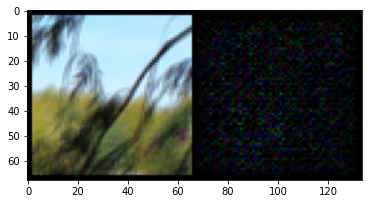

In [34]:
 g = torchvision.utils.make_grid(grid).numpy()
 plt.imshow(np.transpose(g,(1,2,0)))

In [ ]:
def imshow(img,unnormalize=False):
    if unnormalize:
        img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
torch.backends.cudnn.benchmark = True


In [5]:
gen_l2h = l2h.Generator(in_channels=config.model_facts['in_channels']).to(config.DEVICE)
disc_l2h = l2h.Discriminator(in_channels=config.model_facts['in_channels']).to(config.DEVICE)

In [6]:
gen_h2l = h2l.Generator(config.high_res).to(config.DEVICE)
disc_h2l = h2l.Generator(config.low_res).to(config.DEVICE)

In [8]:
def train_adversarial(loader,epoch):
    batches = len(loader)
    # Setup pre-training phase
    for index,(lr,hr) in enumerate(train_loader):
        # Get images
        lr = lr.to(config.DEVICE)
        hr = hr.to(config.DEVICE)

        # Get noise
        zs = np.random.randn(config.training_facts['batch_size'], 1, config.high_res).astype(np.float32)
        zs= torch.from_numpy(zs).to(config.DEVICE)
        label_size = lr.size(0)

        # Forward pass
        lr_gen = gen_h2l(hr,zs) # Fake Low res 
        lr_gen_detach = lr_gen.detach()
        sr = gen_l2h(lr_gen) 

        # Backward pass

        # Write loss during training into Tensorboard
        iters = index + epoch * batches + 1
        utils.plot_examples(gen_l2h,gen_h2l,epoch=epoch,idx=index)

        break

In [9]:
for epoch in range(1):
    train_adversarial(train_loader,epoch)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 256x65536)

In [ ]:
for epoch in range(config.training_facts['start_epoch'],config.training_facts['epochs']):
    pass

In [ ]:
15